Obtain forecasts for Trajectron on CARLA or NuScenes data. Provides:

- predictions overlaid on preprocessed input bitmap (does not use the NuScenes map)
- predictions coded by latent values

When loading earlier versions of CARLA data, checkout tag `v1.0` from `carla-collect` and add it to the Python path
https://github.com/fireofearth/carla-collect

In [1]:
%matplotlib inline
import os
import sys
import json
from glob import glob
from timeit import default_timer as timer

from tqdm import tqdm
import numpy as np
import torch
import dill
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib.colors as colors
import matplotlib.patheffects as pe
import matplotlib.animation as animation

PYTHONAPI_EGG_PATH = f"{ os.environ['HOME'] }/src/carla/PythonAPI/carla/dist/carla-0.9.11-py3.7-linux-x86_64.egg"
sys.path.append('..')
sys.path.append('../../../trajectron')
sys.path.append('../../../..')
sys.path.append(PYTHONAPI_EGG_PATH)

import utility as util
from helper import *
# from model.dataset import *
# from model.components import *
# from model.model_utils import *
from helper import load_model
from model.dataset import get_timesteps_data
from model.model_utils import ModeKeys

AGENT_COLORS = [
        'blue', 'darkviolet', 'dodgerblue', 'darkturquoise',
        'green', 'gold', 'orange', 'red', 'deeppink']
AGENT_COLORS = np.array(AGENT_COLORS) \
        .take([(i * 5) % len(AGENT_COLORS) for i in range(17)], 0)
NCOLORS = len(AGENT_COLORS)

def get_ego_node(nodes):
    nodes = filter(lambda k: 'VEHICLE/ego' in repr(k), nodes)
    return next(nodes)

def get_scene(s):
    sel_scenes = list(filter(lambda scene : scene.name in [s], eval_scenes))
    print(sel_scenes)
    scene = sel_scenes[0]
    return scene

Search datasets

In [2]:
search_datasets = False
dataset_dir = "../../../.."
glob(f"{ dataset_dir }/**/*.pkl") if search_datasets else []

[]

Load a dataset

In [3]:
dataset_0 = util.AttrDict(
    test_set_path='../../processed/nuScenes_test_full.pkl',
    desc="NuScenes test set")

dataset_1 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_dataset/carla_test_v2_full.pkl',
    desc="CARLA synthesized dataset",
    v2_bitmap=True)

dataset_2 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_dataset/carla_test_v2_1_full.pkl',
    desc="CARLA synthesized dataset with bitmap matching NuScenes")

dataset_3 = util.AttrDict(
    test_set_path='/home/fireofearth/code/robotics/carla-collect/carla_v2_1_1_dataset/carla_test_v2_1_1_full.pkl',
    desc="CARLA synthesized dataset smaller sized")

dataset_4 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3_0_1_dataset/carla_test_v3_0_1_full.pkl",
        name='carla_train_v3_0_1',
        desc="CARLA synthesized dataset smaller sized with heading fix",
        v2_bitmap=True)

dataset_5 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3-1_dataset/v3-1_split1_test.pkl",
        name='v3-1_split1_test',
        desc="CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.")

dataset_6 = util.AttrDict(
        test_set_path=f"{ dataset_dir }/carla_v3-1-1_dataset/v3-1-1_split1_test.pkl",
        name='v3-1-1_split1_test',
        desc="CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.")

dataset = dataset_6
with open(dataset.test_set_path, 'rb') as f:
    eval_env = dill.load(f, encoding='latin1')
eval_scenes = eval_env.scenes
print(dataset.desc)

CARLA synthesized dataset with heading fix, occlusion fix, and 32 timesteps.


Search models

In [5]:
search_models = False
[x[0] for x in os.walk('../models')] if search_models else None

Load a model

In [15]:
model_1 = util.AttrDict(
        path='../models/20210622/models_20_Jun_2021_23_53_04_carla_v2_1_dynmap',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on carla v2_1 dataset)")

model_2 = util.AttrDict(
        path='../models/20210603/models_06_Jun_2021_17_02_01_carla_v2_K12',
        desc="Base model +Dynamics Integration, Maps with K=12 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_3 = util.AttrDict(
        path='../models/20210622/models_19_Mar_2021_22_14_19_int_ee_me_ph8',
        desc="Base model +Dynamics Integration, Maps with K=25 latent values "
             "(on NuScenes dataset)")

model_4 = util.AttrDict(
        path='../models/20210713/models_03_Jul_2021_23_44_36_carla_v2_1_dynmap_K6',
        desc="Base model +Dynamics Integration, Maps with K=6 latent values "
             "(on carla v2_1 dataset)")

model_5 = util.AttrDict(
        path='../models/20210610/models_16_Jun_2021_20_33_57_carla_v2_base_ph6',
        desc="Base model with K=25 latent values "
             "(on carla v2 dataset with different bitmap schema)",
        v2_bitmap=True)

model_9 = util.AttrDict(
        path='../models/models_19_Jul_2021_21_09_20_carla_v3_0_1_base_dist_ph6',
        desc="Base model with integrate distribution and heading fix "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_10 = util.AttrDict(
        path='../models/models_19_Jul_2021_22_45_29_carla_v3_0_1_base_distmap_ph6',
        desc="Base +Map model with integrate distribution and heading fix "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_11 = util.AttrDict(
        path='../models/models_20_Jul_2021_11_48_11_carla_v3_0_1_base_distmap_ph8',
        desc="Base +Map model with heading fix, PH=8 "
             "(trained on small carla v3_0_1 dataset)",
        v2_bitmap=True)

model_12 = util.AttrDict(
        path='../models/20210804/models_25_Jul_2021_15_29_29_carla_v3-1_base_distmap_ph8',
        desc="Base +Map model with heading fix, PH=8, K=25 "
             "(trained on carla v3-1 dataset)")

model_13 = util.AttrDict(
        path='../models/20210725/models_25_Jul_2021_15_37_17_carla_v3-1_base_distmap_K20_ph8',
        desc="Base +Map model with heading fix, PH=8, K=20 "
             "(trained on carla v3-1 dataset)")

model_14 = util.AttrDict(
        path='../models/20210725/models_25_Jul_2021_15_38_46_carla_v3-1_base_distmap_K15_ph8',
        desc="Base +Map model with heading fix, PH=8, K=15 "
             "(trained on carla v3-1 dataset)")

model_15 = util.AttrDict(
        path='../models/20210725/models_25_Jul_2021_15_38_20_carla_v3-1_base_distmap_K10_ph8',
        desc="Base +Map model with heading fix, PH=8, K=10 "
             "(trained on carla v3-1 dataset)")

model_16 = util.AttrDict(
        path='../models/20210725/models_25_Jul_2021_15_39_52_carla_v3-1_base_distmap_K5_ph8',
        desc="Base +Map model with heading fix, PH=8, K=5 "
             "(trained on carla v3-1 dataset)")

model_17 = util.AttrDict(
        path='../models/20210801/models_01_Aug_2021_20_02_57_carla_v3-1-1_base_distmapV3_ph8',
        desc="Base +MapV2 model with heading fix, PH=8, K=25 "
             "(trained on smaller carla v3-1-1 dataset)")

model_18 = util.AttrDict(
        path='../models/20210802/models_02_Aug_2021_19_29_27_carla_v3-1-1_base_distmapV4_ph8',
        desc="Base +MapV4 model with heading fix, PH=8, K=25 "
             "(trained on smaller carla v3-1-1 dataset)")

model_19 = util.AttrDict(
        path='../models/20210803/models_03_Aug_2021_13_42_51_carla_v3-1-1_base_distmapV4_ph8',
        desc="Base +MapV4-1 model with heading fix, PH=8, K=25 "
             "(trained on smaller carla v3-1-1 dataset)")

model_20 = util.AttrDict(
        path='../models/20210804/models_04_Aug_2021_19_14_01_carla_v3-1_base_distmapV4_ph8',
        desc="Base +MapV4-1 model with heading fix, PH=8, K=25 "
             "(trained on carla v3-1 dataset)")

model_21 = util.AttrDict(
        path='../models/20210803/models_05_Aug_2021_21_29_38_carla_v3-1-1_base_distmapV4_K5_ph8',
        desc="Base +MapV4-1 model with heading fix, PH=8, K=5 "
             "(trained on smaller carla v3-1-1 dataset)")

model_22 = util.AttrDict(
        path='../models/20210815/models_15_Aug_2021_17_04_28_carla_v3-1-1_base_distmapV4_modfm_ph8',
        desc="??? model "
             "(trained on carla v3-1-1 dataset w/ rebalancing)")



model = model_22
eval_stg, hyp = load_model(model.path, eval_env, ts=40)#, device='cuda')
print(model.desc)


Loading from ../models/20210815/models_15_Aug_2021_17_04_28_carla_v3-1-1_base_distmapV4_modfm_ph8/model_registrar-40.pt
Loaded!

??? model (trained on carla v3-1-1 dataset w/ rebalancing)


### Combining forecast and map

In [16]:
def render_roads(ax, scene, is_white=False):
    road_color = 'white' if is_white else 'grey'
    map_mask = scene.map['VEHICLE'].as_image()
    # map_mask has shape (y, x, c)
    road_bitmap = np.max(map_mask, axis=2)
    road_div_bitmap = map_mask[..., 1]
    lane_div_bitmap = map_mask[..., 0]

    # extent = (scene.x_min, scene.x_max, scene.y_min, scene.y_max)
    extent = (0, scene.x_size, 0, scene.y_size)

    if 'v2_bitmap' in model:
        if 'v2_bitmap' not in dataset:
            print('WARNING: dataset not v2')
        # map_mask has shape (y, x, c)
        road_bitmap = np.max(map_mask, axis=2)
        road_div_bitmap = map_mask[..., 1]
        lane_div_bitmap = map_mask[..., 0]

        # Axes.imshow() expects (y, x, c)
        ax.imshow(road_bitmap,     extent=extent, origin='lower', cmap=colors.ListedColormap(['none', road_color]))
        ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
        ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))
    else:
        if 'v2_bitmap' in dataset:
            print('WARNING: dataset is v2')
        """
        NuScenes bitmap format
        scene.map[...].as_image() has shape (y, x, c)
        Channel 1: lane, road_segment, drivable_area
        Channel 2: road_divider
        Channel 3: lane_divider
        """
        # NuScenes
        road_bitmap = np.max(map_mask, axis=2)
        road_bitmap = map_mask[..., 0]
        road_div_bitmap = map_mask[..., 1]
        lane_div_bitmap = map_mask[..., 2]
        ax.imshow(road_bitmap,     extent=extent, origin='lower', cmap=colors.ListedColormap(['none', road_color]))
        ax.imshow(road_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'yellow']))
        ax.imshow(lane_div_bitmap, extent=extent, origin='lower', cmap=colors.ListedColormap(['none', 'silver']))

In [17]:
num_samples = 100
ph = 8
if 'v2_bitmap' in dataset:
    print("Getting v2 scene")
    scene = eval_scenes[20]
    t = 19
    timesteps = np.array([t])
else:
    # multimodal turn in v3-1 dataset
    scene = eval_scenes[13]
    
    scene = eval_scenes[28]
    
    t = 7
    timesteps = np.array([t])

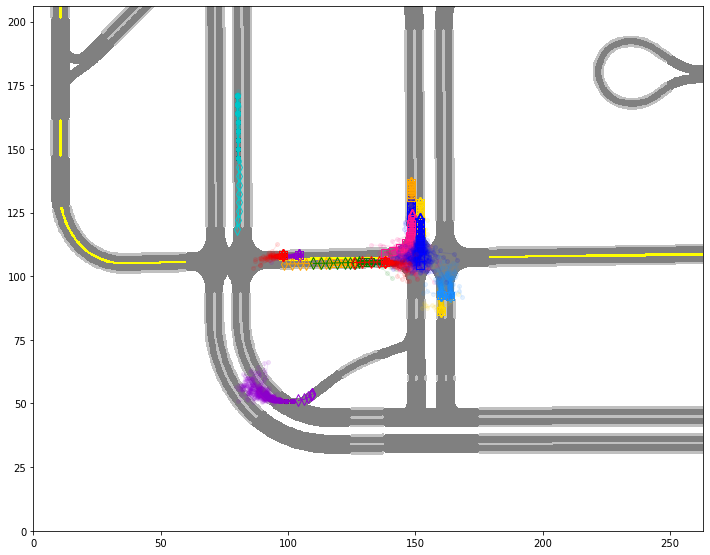

In [23]:
with torch.no_grad():
    # eval_stg the model interface
    predictions = eval_stg.predict(scene,
            timesteps, ph, num_samples=num_samples,
                z_mode=False,
                gmm_mode=False,
                full_dist=False,
                all_z_sep=False)

prediction_dict, histories_dict, futures_dict = \
    prediction_output_to_trajectories(
        predictions, dt=scene.dt, max_h=10, ph=ph, map=None)

v_nodes = list(filter(lambda k: 'VEHICLE' in repr(k), predictions[t].keys()))
v_nodes.sort(key=lambda k: 0 if 'ego' in repr(k) else 1)
node = v_nodes[0]

fig, ax = plt.subplots(figsize=(12,15))
render_roads(ax, scene)

for idx, node in enumerate(v_nodes):
    player_future = futures_dict[t][node]
    player_past = histories_dict[t][node]
    player_predict = prediction_dict[t][node]

    ax.plot(player_future[:,0], player_future[:,1],
                marker='s', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    ax.plot(player_past[:,0], player_past[:,1],
                marker='d', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, markersize=8, markerfacecolor='none')
    for row in player_predict[0]:
        ax.plot(row[:,0], row[:,1],
                marker='o', color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1, alpha=0.1, markersize=4)

extent = np.array([0, scene.x_size, 0, scene.y_size])
should_zoom_in = False
if should_zoom_in:
    zoom = np.array([70, 70])
    extent += np.array([zoom[0], -zoom[0], zoom[1], -zoom[1]])
ax.set_xlim([extent[0], extent[1]])
ax.set_ylim([extent[2], extent[3]])
None

### Plot predictions by latent

In [19]:
def generate_vehicle_latents(
            num_samples = 200,
            z_mode=False, gmm_mode = False, full_dist = False, all_z_sep = False):
    # Trajectron.predict() arguments
    min_future_timesteps = 0
    min_history_timesteps = 1

    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(env=eval_stg.env, scene=scene, t=timesteps, node_type=node_type,
                               state=eval_stg.state,
                               pred_state=eval_stg.pred_state, edge_types=model.edge_types,
                               min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
                               min_ft=min_future_timesteps,
                               max_ft=min_future_timesteps, hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
     x_t, y_t, x_st_t, y_st_t,
     neighbors_data_st,
     neighbors_edge_value,
     robot_traj_st_t,
     map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                               inputs=inputs,
                                                               inputs_st=inputs_st,
                                                               labels=None,
                                                               labels_st=None,
                                                               first_history_indices=first_history_indices,
                                                               neighbors=neighbors,
                                                               neighbors_edge_value=neighbors_edge_value,
                                                               robot=robot,
                                                               map=map)

    model.latent.p_dist = model.p_z_x(mode, x)
    latent_probs = model.latent.get_p_dist_probs() \
            .cpu().detach().numpy()
    latent_probs = np.squeeze(latent_probs)

    z, num_samples, num_components = model.latent.sample_p(num_samples,
                                                          mode,
                                                          most_likely_z=z_mode,
                                                          full_dist=full_dist,
                                                          all_z_sep=all_z_sep)
    
    _, predictions = model.p_y_xz(mode, x, x_nr_t, y_r, n_s_t0, z,
                                            prediction_horizon,
                                            num_samples,
                                            num_components,
                                            gmm_mode)
    z = z.cpu().detach().numpy()
    zz = z
    # z has shape (number of samples, number of vehicles, number of latent values)
    # z[i,j] gives the latent for sample i of vehicle j
#     print(z.shape)
    
    predictions = predictions.cpu().detach().numpy()
    # predictions has shape (number of samples, number of vehicles, prediction horizon, D)
#     print(predictions.shape)

    # predictions_dict is the same as the output from eval_stg.predict()
    print(nodes)
    predictions_dict = dict()
    for i, ts in enumerate(timesteps_o):
        if ts not in predictions_dict.keys():
            predictions_dict[ts] = dict()
        predictions_dict[ts][nodes[i]] = np.transpose(predictions[:, [i]], (1, 0, 2, 3))
    
    z = np.swapaxes(np.argmax(z, axis=-1), 0, 1)
    predictions = np.swapaxes(predictions, 0, 1)
        
    return z, zz, predictions, nodes, predictions_dict, latent_probs

def plot_behavior(scene, z, zz, predictions, nodes):
    latent_size = zz.shape[2]
#     coords = predictions.reshape(-1, 2)
#     x_max, y_max = np.amax(coords, axis=0)
#     x_min, y_min = np.amin(coords, axis=0)
    figwidth  = 20.
#     figheight = figwidth*(13. / 2.)*(y_max - y_min)/(x_max - x_min)
    figheight = (float(latent_size)/25.)*figwidth*(13. / 2.)*(scene.y_size)/(scene.x_size)
    
    _, histories_dict, _ = \
            prediction_output_to_trajectories(
                predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)
    
    n_vehicles = len(nodes)
    colors = cm.nipy_spectral(np.linspace(0, 1, latent_size))
    fig, axes = plt.subplots(latent_size // 2 + latent_size % 2, 2,
            figsize=(figwidth, figheight))
    fig.tight_layout()
    
    for behavior in range(0, latent_size):
        ax = axes[behavior // 2][behavior % 2]
        color = colors[behavior]
        label=f"z = {behavior}"
        for idx, node in enumerate(nodes):
            zn = z[idx]
            pn = predictions[idx]
            mask = zn == behavior
            zn = zn[mask]
            pn = pn[mask]
            player_past = histories_dict[t][node]
            player_past = np.vstack(
                    (player_past, player_past[-1][None] + 5))
            
            ax.plot(player_past[:,0], player_past[:,1],
                    color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1)
            
            for jdx in range(zn.shape[0]):
                ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                        marker='o', color=color,
                        linewidth=1, alpha=0.2, markersize=4,
                        label=label)
                label=None
#         ax.set_xlim([x_min, x_max])
#         ax.set_ylim([y_min, y_max])
        ax.set_xlim([0, scene.x_size])
        ax.set_ylim([0, scene.y_size])
        ax.set_aspect('equal')
        ax.legend(loc='upper right')
        ax.set_facecolor("grey")
#     axes[-1,-1].set_xlim([x_min, x_max])
#     axes[-1,-1].set_ylim([y_min, y_max])
    axes[-1,-1].set_xlim([0, scene.x_size])
    axes[-1,-1].set_ylim([0, scene.y_size])
    axes[-1,-1].set_visible(False)
    return fig, axes

In [20]:
with torch.no_grad():
    z,zz, predictions, nodes, predictions_dict, latent_probs = generate_vehicle_latents(
            num_samples=500,
            z_mode=False, gmm_mode = False,
            full_dist = False, all_z_sep = False)

[VEHICLE/517, VEHICLE/ego, VEHICLE/587, VEHICLE/585, VEHICLE/580, VEHICLE/577, VEHICLE/542, VEHICLE/578, VEHICLE/539, VEHICLE/538, VEHICLE/535, VEHICLE/530, VEHICLE/527, VEHICLE/520, VEHICLE/540]


Plot predictions color coded by latent value

15
VEHICLE/517
VEHICLE/ego
VEHICLE/587
VEHICLE/585
VEHICLE/580
VEHICLE/577
VEHICLE/542
VEHICLE/578
VEHICLE/539
VEHICLE/538
VEHICLE/535
VEHICLE/530
VEHICLE/527
VEHICLE/520
VEHICLE/540


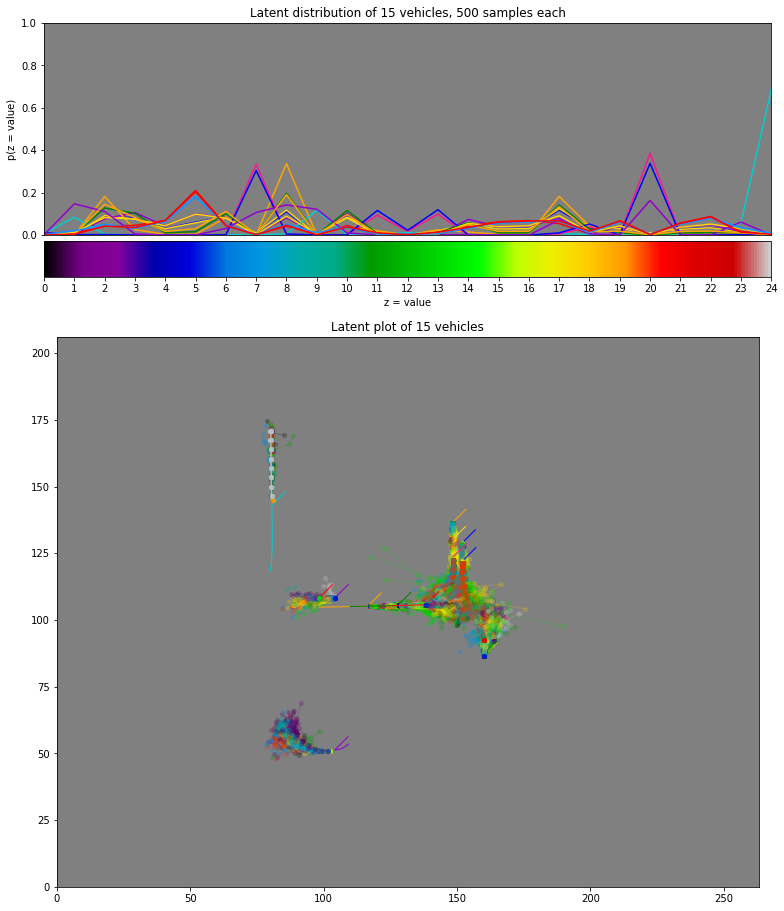

In [21]:
latent_size = zz.shape[2]
latent_colors = cm.nipy_spectral(np.linspace(0, 1, latent_size))
z_counts = np.sum(zz, axis=0) / z.shape[1]
n_vehicles = len(nodes)
print(n_vehicles)

_, histories_dict, _ = \
    prediction_output_to_trajectories(
        predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)

fig, (ax1, ax) = plt.subplots(2, 1, figsize=(11, 16))
fig.tight_layout()

ax1.set_facecolor("grey")
for idx, v_probs in enumerate(latent_probs):
    ax1.plot(range(latent_size), v_probs, c=AGENT_COLORS[idx % NCOLORS])
ax1.set_xlim([0, latent_size - 1])
ax1.set_ylim([0, 1])
ax1.set_aspect(7)
ax1.set_ylabel("p(z = value)")
ax1.set_title(f"Latent distribution of {n_vehicles} vehicles, {z.shape[1]} samples each")
ax1.get_xaxis().set_ticks([])

scalarmappaple = cm.ScalarMappable(cmap=cm.nipy_spectral)
scalarmappaple.set_array(range(0, latent_size))
plt.colorbar(scalarmappaple, ax=ax1, orientation='horizontal',
             pad=0.01,
             ticks=range(0, 25),
             label="z = value")

for idx, node in enumerate(nodes):
    print(node)
    player_past = histories_dict[t][node]
    player_past = np.vstack((player_past, player_past[-1][None] + 5))

    ax.plot(player_past[:,0], player_past[:,1],
            color=AGENT_COLORS[idx % NCOLORS],
            linewidth=1)

    # latent variable z corresponding to vehicle.
    zn = z[idx]
    pn = predictions[idx]
    for jdx in range(zn.shape[0]):
        color = latent_colors[zn[jdx]]
        ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                marker='o',
                 color=color,
                linewidth=1, alpha=0.2, markersize=4)

ax.set_facecolor("grey")
ax.set_title(f"Latent plot of {n_vehicles} vehicles")
ax.set_aspect('equal')
ax.set_xlim([0, scene.x_size])
ax.set_ylim([0, scene.y_size])
fig.tight_layout()

Plot predictions separately for each latent value

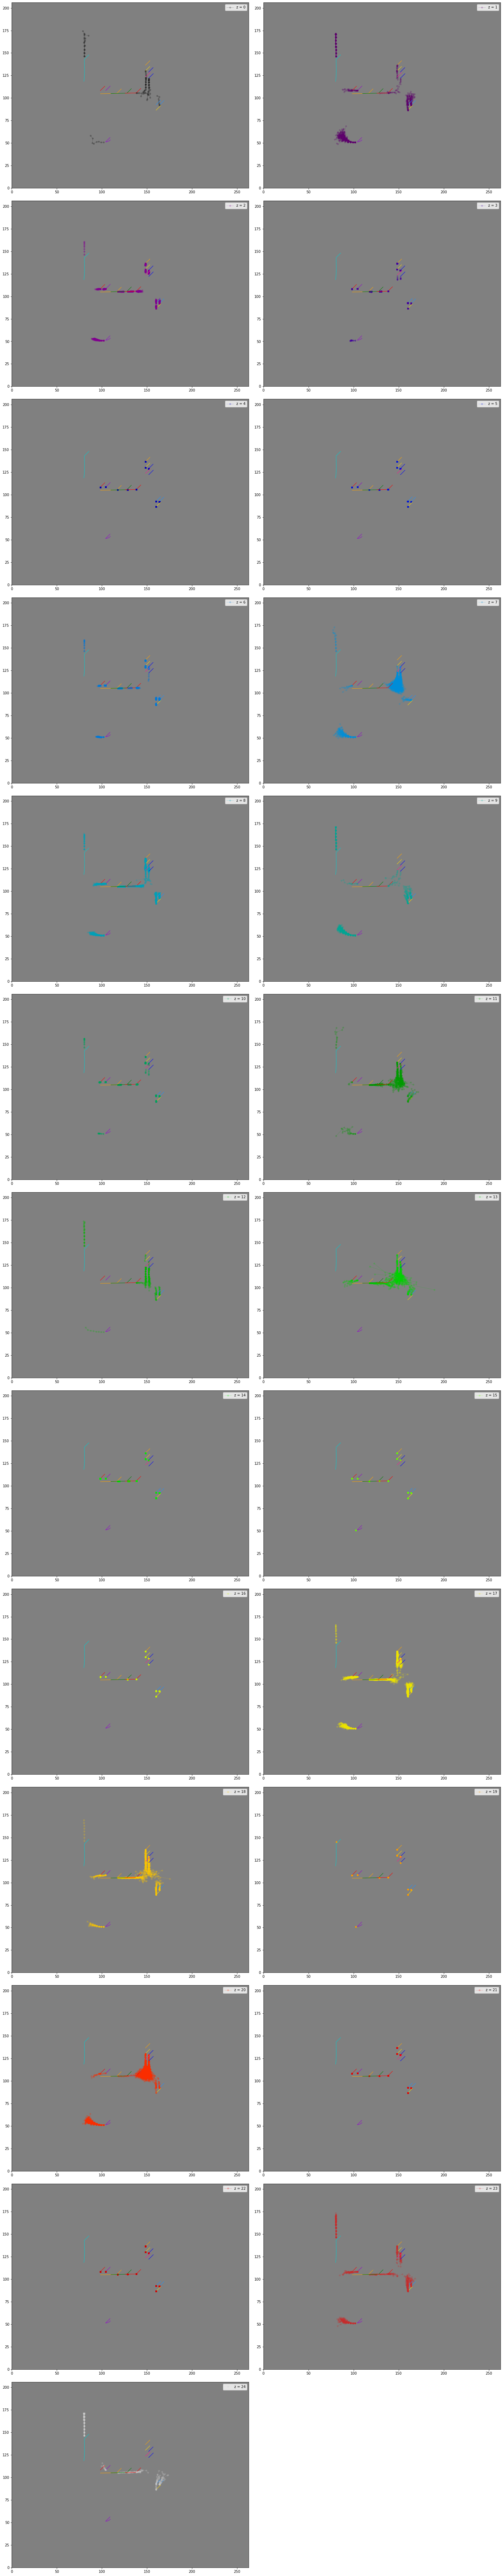

In [22]:
fig, ax = plot_behavior(scene, z, zz, predictions, nodes)

Animation of predictions

In [80]:
def generate_vehicle_latents(
            eval_stg, scene, t, ph, num_samples=200,
            z_mode=False, gmm_mode=False, full_dist=False, all_z_sep=False):
    """Generate predicted trajectories and their corresponding
    latent variables.

    Parameters
    ==========
    eval_stg : torch.nn.Module or object
        The model to do predictions on
    scene : Scene
        The nuScenes scene
    t : int
        The timestep in the scene
    ph : int
        The prediction horizon
    
    Returns
    =======
    z : ndarray
        Has shape (number of vehicles, number of samples)
    zz : ndarray
        Has shape (number of vehicles, number of samples, number of latent values)
    predictions : ndarray
        Has shape (number of vehicles, number of samples, prediction horizon, D)
    nodes : list of Node
        Has size (number of vehicles)
        List of vehicle nodes
    predictions_dict : dict
        Contains map of predictions by timestep, by vehicle node
    latent_probs : ndarray
        The latent PMF of shape (number of latent values,).
    """
    # Trajectron.predict() arguments
    timesteps = np.array([t])
    min_future_timesteps = 0
    min_history_timesteps = 1

    # In Trajectron.predict() scope
    node_type = eval_stg.env.NodeType.VEHICLE
    if node_type not in eval_stg.pred_state:
        raise Exception("fail")

    model = eval_stg.node_models_dict[node_type]

    # Get Input data for node type and given timesteps
    batch = get_timesteps_data(
            env=eval_stg.env, scene=scene,
            t=timesteps, node_type=node_type,
            state=eval_stg.state, pred_state=eval_stg.pred_state,
            edge_types=model.edge_types,
            min_ht=min_history_timesteps, max_ht=eval_stg.max_ht,
            min_ft=min_future_timesteps, max_ft=min_future_timesteps,
            hyperparams=eval_stg.hyperparams)
    
    # There are no nodes of type present for timestep
    if batch is None:
        raise Exception("fail")

    (first_history_index,
    x_t, y_t, x_st_t, y_st_t,
    neighbors_data_st,
    neighbors_edge_value,
    robot_traj_st_t,
    map), nodes, timesteps_o = batch

    x = x_t.to(eval_stg.device)
    x_st_t = x_st_t.to(eval_stg.device)
    if robot_traj_st_t is not None:
        robot_traj_st_t = robot_traj_st_t.to(eval_stg.device)
    if type(map) == torch.Tensor:
        map = map.to(eval_stg.device)

    # MultimodalGenerativeCVAE.predict() arguments
    inputs = x
    inputs_st = x_st_t
    first_history_indices = first_history_index
    neighbors = neighbors_data_st
    neighbors_edge_value = neighbors_edge_value
    robot = robot_traj_st_t
    prediction_horizon = ph

    # In MultimodalGenerativeCVAE.predict() scope
    mode = ModeKeys.PREDICT

    x, x_nr_t, _, y_r, _, n_s_t0 = model.obtain_encoded_tensors(mode=mode,
                                                            inputs=inputs,
                                                            inputs_st=inputs_st,
                                                            labels=None,
                                                            labels_st=None,
                                                            first_history_indices=first_history_indices,
                                                            neighbors=neighbors,
                                                            neighbors_edge_value=neighbors_edge_value,
                                                            robot=robot,
                                                            map=map)

    model.latent.p_dist = model.p_z_x(mode, x)
    latent_probs = model.latent.get_p_dist_probs() \
            .cpu().detach().numpy()
    latent_probs = np.squeeze(latent_probs)
    
    z, num_samples, num_components = model.latent.sample_p(num_samples,
                                                        mode,
                                                        most_likely_z=z_mode,
                                                        full_dist=full_dist,
                                                        all_z_sep=all_z_sep)
    
    _, predictions = model.p_y_xz(mode, x, x_nr_t, y_r, n_s_t0, z,
                                            prediction_horizon,
                                            num_samples,
                                            num_components,
                                            gmm_mode)

    z = z.cpu().detach().numpy()
    zz = z
    # z has shape (number of samples, number of vehicles, number of latent values)
    # z[i,j] gives the latent for sample i of vehicle j
    # print(z.shape)

    # Back to Trajectron.predict() scope    
    predictions = predictions.cpu().detach().numpy()
    # predictions has shape (number of samples, number of vehicles, prediction horizon, D)
    # print(predictions.shape)

    predictions_dict = dict()
    for i, ts in enumerate(timesteps_o):
        if ts not in predictions_dict.keys():
            predictions_dict[ts] = dict()
        predictions_dict[ts][nodes[i]] = np.transpose(predictions[:, [i]], (1, 0, 2, 3))
    
    z = np.swapaxes(np.argmax(z, axis=-1), 0, 1)
    predictions = np.swapaxes(predictions, 0, 1)
        
    return z, zz, predictions, nodes, predictions_dict, latent_probs

In [101]:
def get_predictions_across_scene(scene):
    results = {}
    with torch.no_grad():
        for t in tqdm(range(1, scene.timesteps)):
            z, zz, zpredictions, nodes, predictions_dict, latent_probs = generate_vehicle_latents(
                    eval_stg, scene, t, ph, num_samples=100)

            prediction_dict, histories_dict, futures_dict = \
                    prediction_output_to_trajectories(
                        predictions_dict, dt=scene.dt, max_h=10, ph=ph, map=None)

            result = util.AttrDict(z=z, zz=zz, zpredictions=zpredictions, nodes=nodes, latent_probs=latent_probs,
                    prediction_dict=prediction_dict, histories_dict=histories_dict, futures_dict=futures_dict)

            results[t] = result
    return results


In [102]:
results = get_predictions_across_scene(scene)

100%|██████████| 31/31 [00:02<00:00, 11.60it/s]


at timestep 0
at timestep 0
at timestep 1
at timestep 2
at timestep 3
at timestep 4
at timestep 5
at timestep 6
at timestep 7
at timestep 8
at timestep 9
at timestep 10
at timestep 11
at timestep 12
at timestep 13
at timestep 14
at timestep 15
at timestep 16
at timestep 17
at timestep 18
at timestep 19
at timestep 20
at timestep 21
at timestep 22
at timestep 23
at timestep 24
at timestep 25
at timestep 26
at timestep 27
at timestep 28
at timestep 29
at timestep 30
at timestep 31


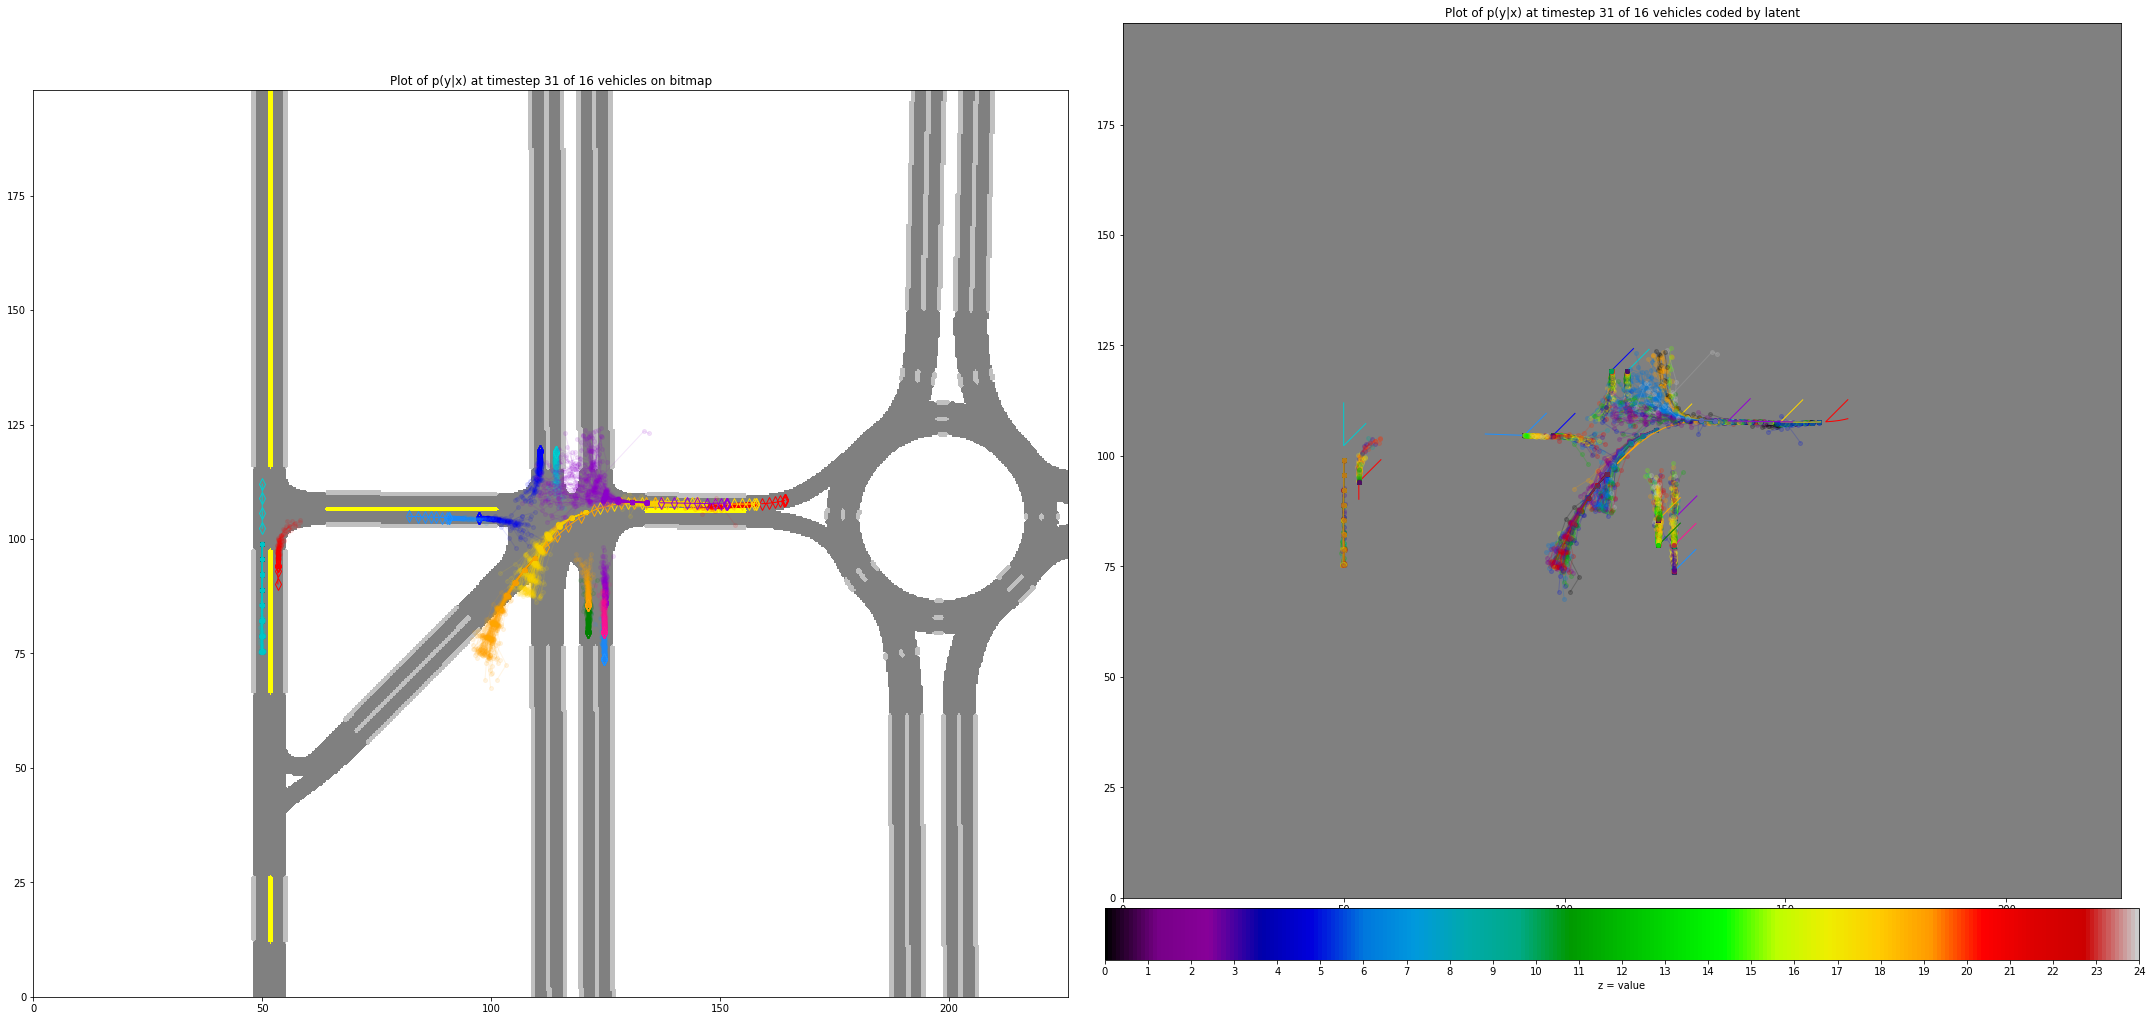

In [104]:
fig, axes = plt.subplots(1, 2, figsize=(30,15))
axes = axes.ravel()

plot_artists = []
plot_artists_across_scenes = {}
def generate_plots_for_timestep(t):
    global plot_artists
    plot_artists_across_scenes[t] = []
    if t < 1 or t >= scene.timesteps:
        return
    
    result = results[t]
    z, zz, zpredictions, nodes, latent_probs, prediction_dict, histories_dict, futures_dict \
            = result.z, result.zz, result.zpredictions, result.nodes, result.latent_probs, \
                result.prediction_dict, result.histories_dict, result.futures_dict
    n_vehicles = len(nodes)

    # Prediction on map
    ax = axes[0]
    render_roads(ax, scene)
    for idx, node in enumerate(nodes):
        player_future = futures_dict[t][node]
        player_past = histories_dict[t][node]
        player_predict = prediction_dict[t][node]

        plot = ax.plot(player_future[:,0], player_future[:,1],
                    marker='s', color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1, markersize=8, markerfacecolor='none')
        plot_artists.extend(plot)
        plot_artists_across_scenes[t].extend(plot)
        plot = ax.plot(player_past[:,0], player_past[:,1],
                    marker='d', color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1, markersize=8, markerfacecolor='none')
        plot_artists.extend(plot)
        plot_artists_across_scenes[t].extend(plot)
        for row in player_predict[0]:
            plot = ax.plot(row[:,0], row[:,1],
                    marker='o', color=AGENT_COLORS[idx % NCOLORS],
                    linewidth=1, alpha=0.1, markersize=4)
            plot_artists.extend(plot)
            plot_artists_across_scenes[t].extend(plot)

    ax.set_title(f"Plot of p(y|x) at timestep {t} of {n_vehicles} vehicles on bitmap")

    # Prediction by latent
    ax = axes[1]
    latent_colors = cm.nipy_spectral(np.linspace(0, 1, hyp['K']))
    # z_counts = np.sum(zz, axis=0) / z.shape[1]

    for idx, node in enumerate(nodes):
        player_past = histories_dict[t][node]
        player_past = np.vstack((player_past, player_past[-1][None] + 5))
        plot = ax.plot(player_past[:,0], player_past[:,1],
                color=AGENT_COLORS[idx % NCOLORS],
                linewidth=1)
        plot_artists.extend(plot)
        plot_artists_across_scenes[t].extend(plot)

        # latent variable z corresponding to vehicle.
        zn = z[idx]
        pn = zpredictions[idx]
        for jdx in range(zn.shape[0]):
            color = latent_colors[zn[jdx]]
            plot = ax.plot(pn[jdx, :, 0], pn[jdx, :, 1],
                    marker='o',
                     color=color,
                    linewidth=1, alpha=0.2, markersize=4)
            plot_artists.extend(plot)
            plot_artists_across_scenes[t].extend(plot)

    ax.set_title(f"Plot of p(y|x) at timestep {t} of {n_vehicles} vehicles coded by latent")

generate_plots_for_timestep(0)
scalarmappaple = cm.ScalarMappable(cmap=cm.nipy_spectral)
scalarmappaple.set_array(range(0, hyp['K']))
plt.colorbar(scalarmappaple, ax=axes[1], orientation='horizontal',
             pad=0.01,
             ticks=range(0, hyp['K']),
             label="z = value")
axes[1].set_facecolor("grey")
axes[1].set_aspect('equal')
for ax in axes:
    ax.set_xlim([0, scene.x_size])
    ax.set_ylim([0, scene.y_size])
fig.tight_layout()

def predictions_of_frame(t, *args):
    print("at timestep", t)
    global plot_artists
    for a in plot_artists:
            a.remove()
    plot_artists = []
    if t not in plot_artists_across_scenes:
        generate_plots_for_timestep(t)
    return plot_artists_across_scenes[t]

# Construct the animation, using the update function as the animation director.
anim = animation.FuncAnimation(fig, predictions_of_frame, frames=scene.timesteps,
                               interval=500, blit=False, repeat=False)
writer = animation.FFMpegWriter(fps=1, codec="h264", extra_args=["-preset", "veryslow","-crf","0"])
anim.save(f"predict_scene.mp4", writer=writer)
plt.show()